In [2]:
# ==========================================
# Monte Carlo: Oracle vs Two-Step vs One-Step
# + Controlled Counterfactual (fixed C) B
# ==========================================

import numpy as np
import statsmodels.api as sm
import jax.numpy as jnp
from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import NUTS, MCMC
import arviz as az

# --------------------------
# 0) Reproducibility & RNGs
# --------------------------
rng = np.random.default_rng(42)     # main RNG for simulation
rng_cf = np.random.default_rng(123) # RNG for counterfactual proxies (independent)

# -------------
# 1) Design
# -------------
T = 800                      # days
gamma0, gamma1 = 0.0, 0.02   # true effect of theta on returns
rho = 0.95                   # AR(1) persistence of theta
tau = 0.05                   # innovation sd of theta
sigma_y = 0.01               # return noise sd
sigma_fin = 0.6              # headline measurement sd (per headline)
C_low, C_high = 2, 30        # min/max daily headline counts

# -------------------------------------
# 2) Simulate latent theta_t (AR(1))
# -------------------------------------
theta = np.zeros(T)
theta[0] = rng.normal(0, tau / np.sqrt(1 - rho**2))
for t in range(1, T):
    theta[t] = rho * theta[t-1] + rng.normal(0, tau)

# ----------------------------------------------
# 3) Simulate headlines (only needed for one-step)
# ----------------------------------------------
C_t = rng.integers(C_low, C_high + 1, size=T)
sbar = np.empty(T)
for t in range(T):
    s_tj = theta[t] + rng.normal(0, sigma_fin, size=C_t[t])
    sbar[t] = s_tj.mean()

# --------------------------
# 4) Simulate returns
# --------------------------
R = gamma0 + gamma1 * theta + rng.normal(0, sigma_y, size=T)

# --------------------------
# 5) Helper: OLS wrapper
# --------------------------
def ols(y, x, addc=True):
    X = sm.add_constant(x) if addc else x
    return sm.OLS(y, X).fit()

# ------------------------------------------------
# 6) Oracle (infeasible): regress on true theta
# ------------------------------------------------
res_oracle = ols(R, theta)
b0, b1 = res_oracle.params
se0, se1 = res_oracle.bse
ci_lo, ci_hi = b1 - 1.96*se1, b1 + 1.96*se1

print("--- Oracle (infeasible) ---")
print(f"Intercept: {b0:.6f} (SE {se0:.6f})")
print(f"Slope:     {b1:.6f} (SE {se1:.6f}), 95% CI [{ci_lo:.6f}, {ci_hi:.6f}]")

print(f"\nTrue gamma1: {gamma1:.4f}")

# ------------------------------------------------------------------
# 7) CONTROLLED COUNTERFACTUAL (Option B): fixed C each day
# ------------------------------------------------------------------
def build_sbar_fixed_C(theta_arr, C_fixed, sigma_fin, rng_local):
    noise = rng_local.normal(0.0, sigma_fin, size=(len(theta_arr), C_fixed))
    return theta_arr + noise.mean(axis=1)

def ols_summary(y, x, label):
    res = ols(y, x)
    b0, b1 = res.params
    se0, se1 = res.bse
    ci_lo, ci_hi = b1 - 1.96*se1, b1 + 1.96*se1
    corr = np.corrcoef(theta, x)[0, 1]
    print(f"\n--- Feasible two-step (R ~ sbar_fixed) [{label}] ---")
    print(f"Intercept: {b0:.6f} (SE {se0:.6f})")
    print(f"Slope:     {b1:.6f} (SE {se1:.6f}), 95% CI [{ci_lo:.6f}, {ci_hi:.6f}]")
    print(f"corr(theta, sbar_fixed)={corr:.3f}, Var(sbar_fixed)={np.var(x):.4f}")
    return res, (ci_lo, ci_hi)

C_low_fixed, C_high_fixed = 2, 30
sbar_lowfix  = build_sbar_fixed_C(theta, C_low_fixed,  sigma_fin, rng_cf)
sbar_highfix = build_sbar_fixed_C(theta, C_high_fixed, sigma_fin, rng_cf)

res_low,  ci_low  = ols_summary(R, sbar_lowfix,  f"LOW fixed C={C_low_fixed}")
res_high, ci_high = ols_summary(R, sbar_highfix, f"HIGH fixed C={C_high_fixed}")

# -------------------------------------------------------------
# 8) ONE-STEP AR(1) with NumPyro (aggregated measurement)
# -------------------------------------------------------------
def model_ar1_agg(T, y, sbar, C):
    rho = numpyro.sample("rho", dist.Uniform(-0.95, 0.95))
    tau = numpyro.sample("tau", dist.HalfNormal(1.0))
    mu_theta = numpyro.sample("mu_theta", dist.Normal(0.0, 1.0))
    sigma0 = tau / jnp.sqrt(1.0 - rho**2 + 1e-8)
    theta0 = numpyro.sample("theta_0", dist.Normal(mu_theta, sigma0))
    eps = numpyro.sample("eps", dist.Normal(0.0, 1.0).expand([T-1]).to_event(1))
    import jax.lax as lax
    def step(prev, e):
        mean_t = mu_theta * (1 - rho) + rho * prev
        return mean_t + tau * e, mean_t + tau * e
    _, theta_tail = lax.scan(step, theta0, eps)
    theta_latent = jnp.concatenate([theta0[None], theta_tail])
    numpyro.deterministic("theta", theta_latent)
    sigma_fin_param = numpyro.sample("sigma_fin", dist.HalfNormal(0.5))
    numpyro.sample("sbar_obs",
                   dist.Normal(theta_latent, sigma_fin_param / jnp.sqrt(jnp.clip(C, 1.0, 1e9))),
                   obs=sbar)
    gamma0_param = numpyro.sample("gamma0", dist.Normal(0.0, 0.01))
    gamma1_param = numpyro.sample("gamma1", dist.Normal(0.0, 0.01))
    sigma_y_param = numpyro.sample("sigma_y", dist.HalfNormal(0.01))
    numpyro.sample("y_obs",
                   dist.Normal(gamma0_param + gamma1_param * theta_latent, sigma_y_param),
                   obs=y)

# Prepare arrays for JAX
T_jnp, y_jnp = int(T), jnp.asarray(R)
sbar_jnp, C_jnp = jnp.asarray(sbar), jnp.asarray(C_t)

rng_key = random.PRNGKey(0)
nuts    = NUTS(model_ar1_agg, target_accept_prob=0.9)
mcmc    = MCMC(nuts, num_warmup=800, num_samples=1200, num_chains=2,
               chain_method="sequential", progress_bar=True)
mcmc.run(rng_key, T=T_jnp, y=y_jnp, sbar=sbar_jnp, C=C_jnp)

idata = az.from_numpyro(mcmc)
summ  = az.summary(idata, var_names=["gamma0","gamma1","sigma_y","rho","tau","sigma_fin"], round_to=6)
print("\n=== One-step AR(1) posterior summary ===")
print(summ)

# Posterior mean and 95% HDI for gamma1
g1_mean = float(idata.posterior["gamma1"].mean().values)
hdi_ds  = az.hdi(idata, var_names=["gamma1"], hdi_prob=0.95)
g1_lo, g1_hi = float(hdi_ds["gamma1"].sel(hdi="lower").values), float(hdi_ds["gamma1"].sel(hdi="higher").values)

print("\n=== Comparison ===")
print(f"True gamma1:                        {gamma1:.6f}")
print(f"Oracle slope (R~theta):             {res_oracle.params[1]:.6f}, 95% CI=({ci_lo:.6f}, {ci_hi:.6f})")
print(f"Feasible LOW fixed C={C_low_fixed}: {res_low.params[1]:.6f}, 95% CI=({ci_low[0]:.6f}, {ci_low[1]:.6f})")
print(f"Feasible HIGH fixed C={C_high_fixed}: {res_high.params[1]:.6f}, 95% CI=({ci_high[0]:.6f}, {ci_high[1]:.6f})")
print(f"One-step AR(1): mean={g1_mean:.6f}, 95% HDI=({g1_lo:.6f}, {g1_hi:.6f})")


c:\Users\49176\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


--- Oracle (infeasible) ---
Intercept: 0.000138 (SE 0.000364)
Slope:     0.016423 (SE 0.002593), 95% CI [0.011341, 0.021506]

True gamma1: 0.0200

--- Feasible two-step (R ~ sbar_fixed) [LOW fixed C=2] ---
Intercept: -0.000321 (SE 0.000363)
Slope:     0.001885 (SE 0.000800), 95% CI [0.000316, 0.003453]
corr(theta, sbar_fixed)=0.289, Var(sbar_fixed)=0.2053

--- Feasible two-step (R ~ sbar_fixed) [HIGH fixed C=30] ---
Intercept: -0.000094 (SE 0.000364)
Slope:     0.009290 (SE 0.002068), 95% CI [0.005237, 0.013343]
corr(theta, sbar_fixed)=0.792, Var(sbar_fixed)=0.0302


sample: 100%|██████████| 2000/2000 [00:14<00:00, 137.48it/s, 63 steps of size 7.81e-02. acc. prob=0.93]



=== One-step AR(1) posterior summary ===
               mean        sd    hdi_3%   hdi_97%  mcse_mean   mcse_sd  \
gamma0     0.000139  0.000378 -0.000573  0.000838   0.000008  0.000007   
gamma1     0.014273  0.002831  0.009281  0.019805   0.000050  0.000057   
sigma_y    0.010078  0.000259  0.009601  0.010573   0.000003  0.000006   
rho        0.913958  0.021324  0.877349  0.949554   0.000727  0.000489   
tau        0.057469  0.006857  0.044786  0.069491   0.000273  0.000130   
sigma_fin  0.579731  0.018849  0.543457  0.615113   0.000528  0.000308   

              ess_bulk     ess_tail     r_hat  
gamma0     2421.724097  1907.216980  1.000919  
gamma1     3189.070525  1838.719046  1.001102  
sigma_y    5523.741608  1603.398761  0.999464  
rho         867.370436  1360.338867  1.000164  
tau         635.689800  1299.015503  1.002603  
sigma_fin  1267.241589  2132.918017  1.000257  

=== Comparison ===
True gamma1:                        0.020000
Oracle slope (R~theta):             0.

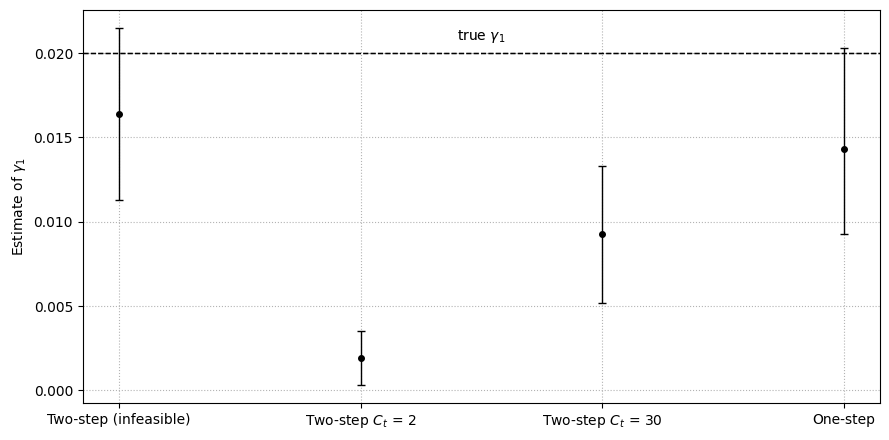

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Beispiel-Daten (ersetzen mit deinen Schätzern & Intervallen)
labels = [r"Two-step (infeasible)", r"Two-step $C_t$ = 2", 
          r"Two-step $C_t$ = 30", r"One-step"]
means  = [0.0164, 0.0019, 0.0093, 0.0143]
lower  = [0.0113, 0.0003, 0.0052, 0.0093]
upper  = [0.0215, 0.0035, 0.0133, 0.0203]

# Fehler nach unten/oben
err_low  = np.array(means) - np.array(lower)
err_high = np.array(upper) - np.array(means)

# --- Plot ---
fig, ax = plt.subplots(figsize=(9, 4.5))  # <- angepasst

ax.errorbar(
    x=np.arange(len(labels)),
    y=means,
    yerr=[err_low, err_high],
    fmt='o',
    color='black',
    ecolor='black',
    elinewidth=1,
    capsize=3,
    markersize=4
)

# Achsen, Grid, Layout
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_ylabel(r"Estimate of $\gamma_1$")
# Referenzlinie in grau + Label
ax.axhline(0.0200, linestyle='--', color='gray', linewidth=1)
xmid = (ax.get_xlim()[0] + ax.get_xlim()[1]) / 2
ax.text(xmid, 0.0200 + 0.0005, r"true $\gamma_1$", ha='center', va='bottom', fontsize=10, color='lightgrey')
ax.grid(True, which='both', linestyle=':', color='0.7')         # angedeutetes Grid

ax.axhline(0.0200, linestyle='--', color='black', linewidth=1)

# Text mittig über der Linie
xmid = (ax.get_xlim()[0] + ax.get_xlim()[1]) / 2
ax.text(
    xmid, 0.0200 + 0.0005,           # leicht oberhalb der Linie
    r"true $\gamma_1$", 
    ha='center', va='bottom',
    fontsize=10
)

fig.tight_layout()
plt.savefig("ci_plot_black.pdf")   # Vektor für Paper
plt.savefig("ci_plot_black.png", dpi=300)
plt.show()


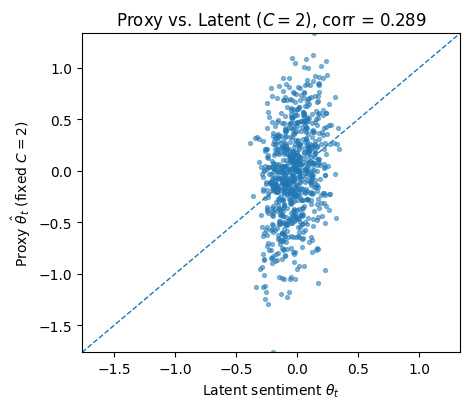

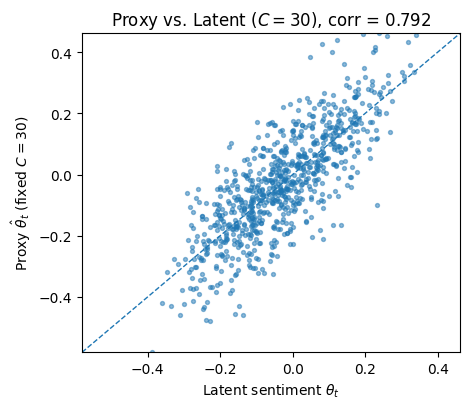

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# correlations for annotation
corr_c2  = float(np.corrcoef(theta, sbar_lowfix)[0, 1])
corr_c30 = float(np.corrcoef(theta, sbar_highfix)[0, 1])

# --- C = 2 ---
plt.figure(figsize=(4.8, 4.2))
plt.scatter(theta, sbar_lowfix, s=8, alpha=0.5)
# 45-degree reference
lims = [min(theta.min(), sbar_lowfix.min()), max(theta.max(), sbar_lowfix.max())]
plt.plot(lims, lims, linestyle='--', linewidth=1)
plt.xlim(lims); plt.ylim(lims)
plt.xlabel(r"Latent sentiment $\theta_t$")
plt.ylabel(r"Proxy $\hat\theta_t$ (fixed $C=2$)")
plt.title(r"Proxy vs. Latent ($C{=}2$), corr = %.3f" % corr_c2)
plt.tight_layout()
plt.savefig("proxy_vs_theta_C2.png", dpi=200)
# plt.show()

# --- C = 30 ---
plt.figure(figsize=(4.8, 4.2))
plt.scatter(theta, sbar_highfix, s=8, alpha=0.5)
lims = [min(theta.min(), sbar_highfix.min()), max(theta.max(), sbar_highfix.max())]
plt.plot(lims, lims, linestyle='--', linewidth=1)
plt.xlim(lims); plt.ylim(lims)
plt.xlabel(r"Latent sentiment $\theta_t$")
plt.ylabel(r"Proxy $\hat\theta_t$ (fixed $C=30$)")
plt.title(r"Proxy vs. Latent ($C{=}30$), corr = %.3f" % corr_c30)
plt.tight_layout()
plt.savefig("proxy_vs_theta_C30.png", dpi=200)
# plt.show()
